In [1]:
import importlib.machinery

loader = importlib.machinery.SourceFileLoader("data_import", "../../utils/data_import.py")
data_import = loader.load_module()

loader = importlib.machinery.SourceFileLoader("model_evaluator", "../../utils/model_evaluator.py")
model_evaluator = loader.load_module()
import numpy as np
import pandas as pd
from sklearn.svm import SVC
import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import roc_curve
import plotly.express as px
from sklearn.decomposition import PCA
import plotly.graph_objects as go
from plotly import tools
from sklearn.preprocessing import StandardScaler

In [2]:
X_tot, df_tot, X_train, X_test, y_train, y_test = data_import.import_data_train_test('Contagio')

## Linear SVM

In [5]:
# define range of possible C values
C_values = np.linspace(10e-6, 10, 10)

In [6]:
run_cross_validation = False #True: run grid search cross validation | False: laod data from CSV

In [7]:
# NOTE: running this takes about 100 minutes
if run_cross_validation:
    params_grid = {
        'C': C_values
    }
    kfold_scores = model_evaluator.grid_search_kfold_cv(X=X_train, y=y_train, model=SVC(kernel='linear'), params_grid=params_grid, k=5)
    print(kfold_scores.best_params_)
    print(model_evaluator.kfold_metrics(kfold_scores.best_estimator_, X_train, y_train))
    # Export results to csv
    df_results = pd.DataFrame({'C': [p['C'] for p in kfold_scores.cv_results_['params']],
                            'accuracy': kfold_scores.cv_results_['mean_test_accuracy'],
                            'fnr': -kfold_scores.cv_results_['mean_test_fnr']})
    df_results.to_csv('linear_svm_results.csv', index=False)

In [8]:
# NOTE: run this to just laod the CSV with the results of cross validation
if run_cross_validation == False:
    df_results = pd.read_csv('linear_svm_results.csv')

### Linear SVM: accuracy and FNR on Training Set

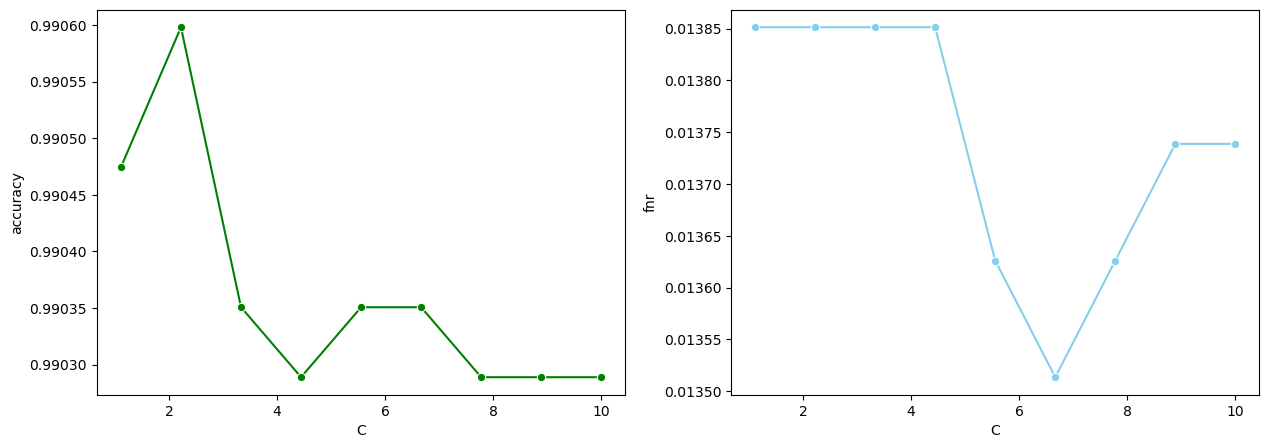

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
g_acc_2 = sns.lineplot(ax=axes[0], data=df_results[df_results['C'] >= 0.001], x='C', y='accuracy', marker="o", errorbar=None, legend=True, color='green')
g_fnr_2 = sns.lineplot(ax=axes[1], data=df_results[df_results['C'] >= 0.001], x='C', y='fnr', marker="o", errorbar=None, legend=True, color='skyblue')

Best results are obtained with:
- $C=6.66667$
- $FNR = \frac{FN}{FN+TP} = 0.0135$
- $Accuracy = 0.99078$

## RBF Kernel SVM

In [10]:
gamma_values = np.linspace(10e-6, 1, 10)
C_values = np.linspace(10e-6, 10, 10)

In [11]:
run_cross_validation = False #True: run grid search cross validation | False: laod data from CSV

In [12]:
# NOTE: running this takes about 100 minutes
if run_cross_validation:
    params_grid = {
        'gamma': gamma_values,
        'C': C_values
    }
    kfold_scores = model_evaluator.grid_search_kfold_cv(X=X_train, y=y_train, model=SVC(kernel='rbf'), params_grid=params_grid, k=5)
    print(kfold_scores.best_params_)
    print(model_evaluator.kfold_metrics(kfold_scores.best_estimator_, X_train, y_train))
    df_results = pd.DataFrame({'C': [p['C'] for p in kfold_scores.cv_results_['params']],
                           'gamma': [p['gamma'] for p in kfold_scores.cv_results_['params']],
                           'accuracy': kfold_scores.cv_results_['mean_test_accuracy'],
                           'fnr': -kfold_scores.cv_results_['mean_test_fnr']})
    df_results.to_csv('rbf_svm_results.csv', index=False)

In [13]:
# NOTE: run this to just laod the CSV with the results of cross validation
if run_cross_validation == False:
    df_results = pd.read_csv('rbf_svm_results.csv')

What it can be noticed is that the influence of $\gamma$ is much stronger and more evident than the influence of the $C$ parameter. When the value of $\gamma$ is sufficiently small the accuracy reaches the top values and the same for the FNR that reaches the lowest possible values. What is not displayed in the plot is what happens with $C=10^{-5}$ and $\gamma=10^{-5}$, parameters under which the classifier performs a very poor analysis in terms of accuracy (around $54%$) but with $FPR=0$. This is not better than a dummy classifier so we don't take into account this values anymore.

We still optimize for the $FPR$ but without considering this corner case:

In [16]:
df_results_mod = df_results[df_results['accuracy'] > 0.9].reset_index()
best_params_accuracy = df_results_mod[df_results_mod['fnr'] == df_results_mod['fnr'].min()].reset_index()
best_C, best_gamma = best_params_accuracy.iloc[0,:].C, best_params_accuracy.iloc[0,:].gamma
print('Best parameters in terms of accuracy: C=%.4f, gamma=%.4f'%(best_C, best_gamma))
print('Performances: accuracy=%.4f, FNR=%.4f'%(best_params_accuracy.iloc[0,:].accuracy, best_params_accuracy.iloc[0,:].fnr))

Best parameters in terms of accuracy: C=5.5556, gamma=0.1111
Performances: accuracy=0.9950, FNR=0.0082


## Performance analysis on the Test Set

Now i am going to train the RBF SVM on the entire training set with the selected optimal parameters:

$C = 5.5556$, $\gamma = 0.1111$

And i make predictions for each sample of `X_test`:

In [55]:
rbf_svm_test = SVC(kernel='rbf', C=best_C, gamma=best_gamma).fit(X_train,y_train)
rbf_metrics = model_evaluator.kfold_metrics(rbf_svm_test, X_test, y_test)
print('## Performance on Test test for RBF SVM (C=5.5556, gamma=0.1111) ##')
print('FNR = %.2f%%\nAccuracy = %.2f%%'%(rbf_metrics['false_neg']*100, rbf_metrics['accuracy_score']*100))

## Performance on Test test for RBF SVM (C=5.5556, gamma=0.1111) ##
FNR = 0.36%
Accuracy = 99.73%


## Attack a kernel SVM

### Gradient Descent evasion attack

See Cuan et al. (https://hal.science/hal-01704766/file/Malware%20Detection%20in%20PDF%20Files%20Using%20Machine%20Learning%20SECRYPT'18.pdf) and Li et al (https://www.sciencedirect.com/science/article/pii/S2352864821001000).

In [17]:
def grad_f_phi_xn(x_n,svm_rbf_clf,X_train,y_train,gamma):
    i = 0
    res = 0
    for sv in svm_rbf_clf.support_: 
        alpha = svm_rbf_clf.dual_coef_[0][i]
        y = 1 if y_train[i] is True else -1 
        x_i = X_train[sv:sv+1] 
        rbf = rbf_kernel(x_i,x_n,gamma=gamma)
        res += alpha * y * (x_i - x_n) * rbf
        i += 1
    return -2 * gamma * res

def iterative_GD_evasion(svm_rbf_clf, X_train, x0, y_train, gamma, step, iprint=True, save_updates=False):
    n = 0
    x_n = x0
    if iprint:
        print('Starting prediction value = %.3f'%(svm_rbf_clf.decision_function(x_n)))
        print('Step size = %.3f\n'%(gamma))
    updates=[]
    while True:
        grad_f_phi = grad_f_phi_xn(x_n,svm_rbf_clf,X_train,y_train,gamma)
        # Compute the perturbation
        x_n = x_n - step * grad_f_phi
        if save_updates:
            updates.append(x_n)
        # Print logs
        if iprint:
            print('--- Evasion step: %d ---'%(n))
            print('Prediction value = %.3f'%(svm_rbf_clf.decision_function(x_n)))
            print('Prediction label = ', svm_rbf_clf.predict(x_n)[0])
            print('Gradient: ', grad_f_phi)
            #print('Norm^2 of gradient: %.3f'%(np.linalg.norm(grad_f_phi)**2))
            print('-------------------------')
        # Check if the sample has become benign
        if svm_rbf_clf.predict(x_n)[0] == False:
            break
        else:
            n += 1
    if iprint:
        print('Evasion completed in %d iterations'%(n+1))
    if save_updates:
        return x_n, n+1, np.concatenate(updates)
    else:
        return  x_n, n+1

In [18]:
# Attack a random malicious PDF (classified malicious by the RBF SVM)
svm_rbf_clf = SVC(kernel='rbf', C=best_C, gamma=best_gamma)
svm_rbf_clf.fit(X_train, y_train)
# now i choose a random malign sample
x0 = df_tot[df_tot['malware'] == True].drop(["malware"], axis=1).iloc[0:1].values.astype(int)
# Perform the evasion
x_crafted, iter = iterative_GD_evasion(svm_rbf_clf, X_train, x0, y_train, best_gamma, 0.05, iprint=False, save_updates=False)
print('Evasion completed in %d iterations'%(iter))

Evasion completed in 9 iterations


In [19]:
svm_rbf_clf.predict(np.ceil(x_crafted)) # now it's predicted as benign

array([False])